# Dataset Overview

speech audio
| Feature              | Details                                                                      |
| -------------------- | ---------------------------------------------------------------------------- |
| **Total Files**      | 1,440 .wav audio files                                                     |
| **Sampling Rate**    | 48 kHz                                                                       |
| **Bit Depth**        | 16-bit                                                                       |
| **Actors**           | 24 total (12 male, 12 female)                                                |
| **Sentences**        | 1. “Kids are talking by the door”  <br> 2. “Dogs are sitting by the door”    |
| **Emotions**         | Neutral, Calm, Happy, Sad, Angry, Fearful, Disgust, Surprised                |
| **Intensity Levels** | - Normal (01)  <br> - Strong (02) <br> *Note: Neutral has no strong version* |


# File Naming Convention
setiap audio di format dengan 7 angka:
03-01-06-01-02-01-12.wav

Breakdown:
| Segment | Description                          | Example |
| ------- | ------------------------------------ | ------- |
| 03      | Modality (03 = audio-only)           | 03      |
| 01      | Vocal channel (01 = speech)          | 01      |
| 06      | Emotion (e.g., 06 = fearful)         | 06      |
| 01      | Intensity (01 = normal, 02 = strong) | 01      |
| 02      | Statement (01 = kids, 02 = dogs)     | 02      |
| 01      | Repetition (01 or 02)                | 01      |
| 12      | Actor ID (01–24, even = female)      | 12      |

*cth: 03-01-06-01-02-01-12.wav*
*→ Audio-only, speech, fearful, normal intensity, “dogs” sentence, 1st repetition, female actor (ID 12)*



# Import Library

In [1]:
# Sistema e warnings
import os
import sys
import warnings

# Dados e manipulação
import numpy as np
import pandas as pd
from tqdm import tqdm

# Áudio e visualização
import librosa
import seaborn as sns
import matplotlib.pyplot as plt

# Pré-processamento e métricas
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef


# Keras para modelagem
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Configura filtros para warnings, para evitar poluição do output
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

---

# Loading and Organizing Audio Files

In [2]:
Audios = "ravdess"

dir_rav = os.listdir(Audios)  

file_emotion = []
file_path = []

for dir_name in dir_rav:
    actor_path = os.path.join(Audios, dir_name)
    for file in os.listdir(actor_path):
        if file.endswith('.wav'):
            parts = file.split('.')[0].split('-')
            emotion_code = int(parts[2])
            file_emotion.append(emotion_code)
            file_path.append(os.path.join(actor_path, file))

emotion = pd.DataFrame(file_emotion, columns=['Emotions'])
path = pd.DataFrame(file_path, columns=['Path'])

data = pd.concat([emotion, path], axis=1)

emotion_map = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}

data['Emotions'] = data['Emotions'].map(emotion_map)

EmotionData = "EmotionData"
os.makedirs(EmotionData, exist_ok=True)

data.to_csv(os.path.join(EmotionData, "data.csv"), index=False)

data.head()

,Emotions,Path
0,neutral,ravdess\Actor_01\03-01-01-01-01-01-01.wav
1,neutral,ravdess\Actor_01\03-01-01-01-01-02-01.wav
2,neutral,ravdess\Actor_01\03-01-01-01-02-01-01.wav
3,neutral,ravdess\Actor_01\03-01-01-01-02-02-01.wav
4,calm,ravdess\Actor_01\03-01-02-01-01-01-01.wav


# Emotion Distribution

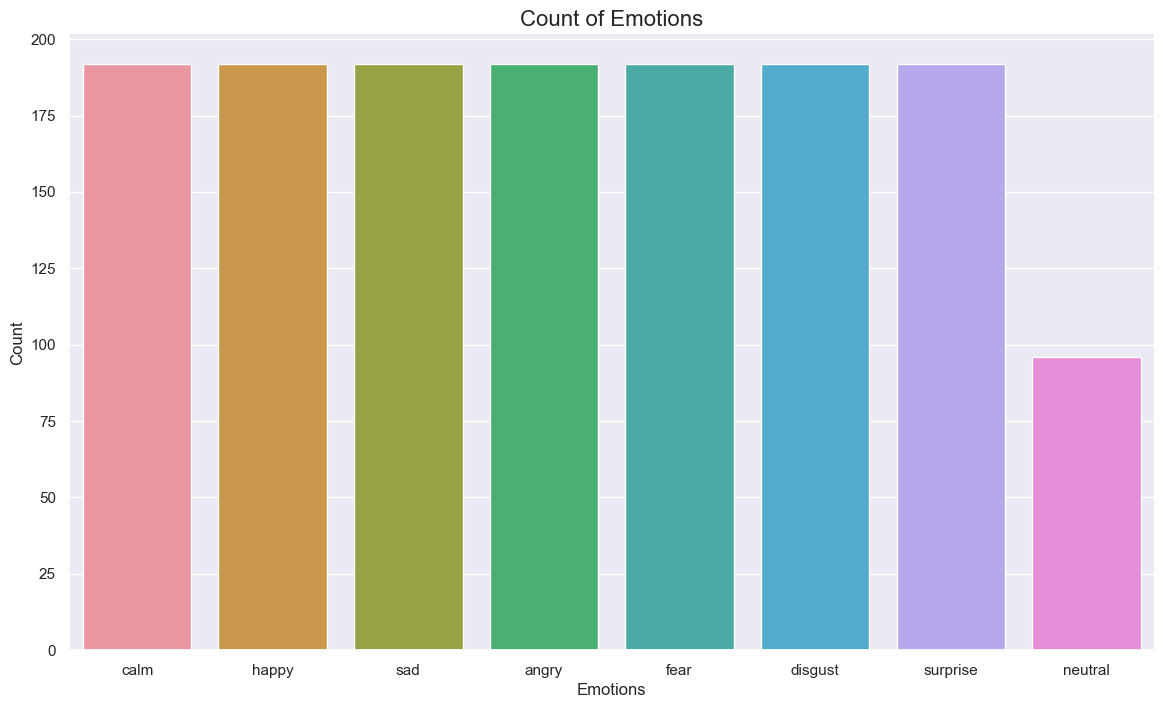

In [3]:
sns.set_theme(context='notebook', style='darkgrid', palette='mako', font='sans-serif', font_scale=1, color_codes=True, rc=None)
plt.figure(figsize=(14, 8))
sns.countplot(x='Emotions', data=data, order=data['Emotions'].value_counts().index)
plt.title('Count of Emotions', size=16)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True)
plt.savefig(os.path.join(EmotionData, "emotions_plot.png"))
plt.show()

# Spectrogram Visualization

In [4]:
def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

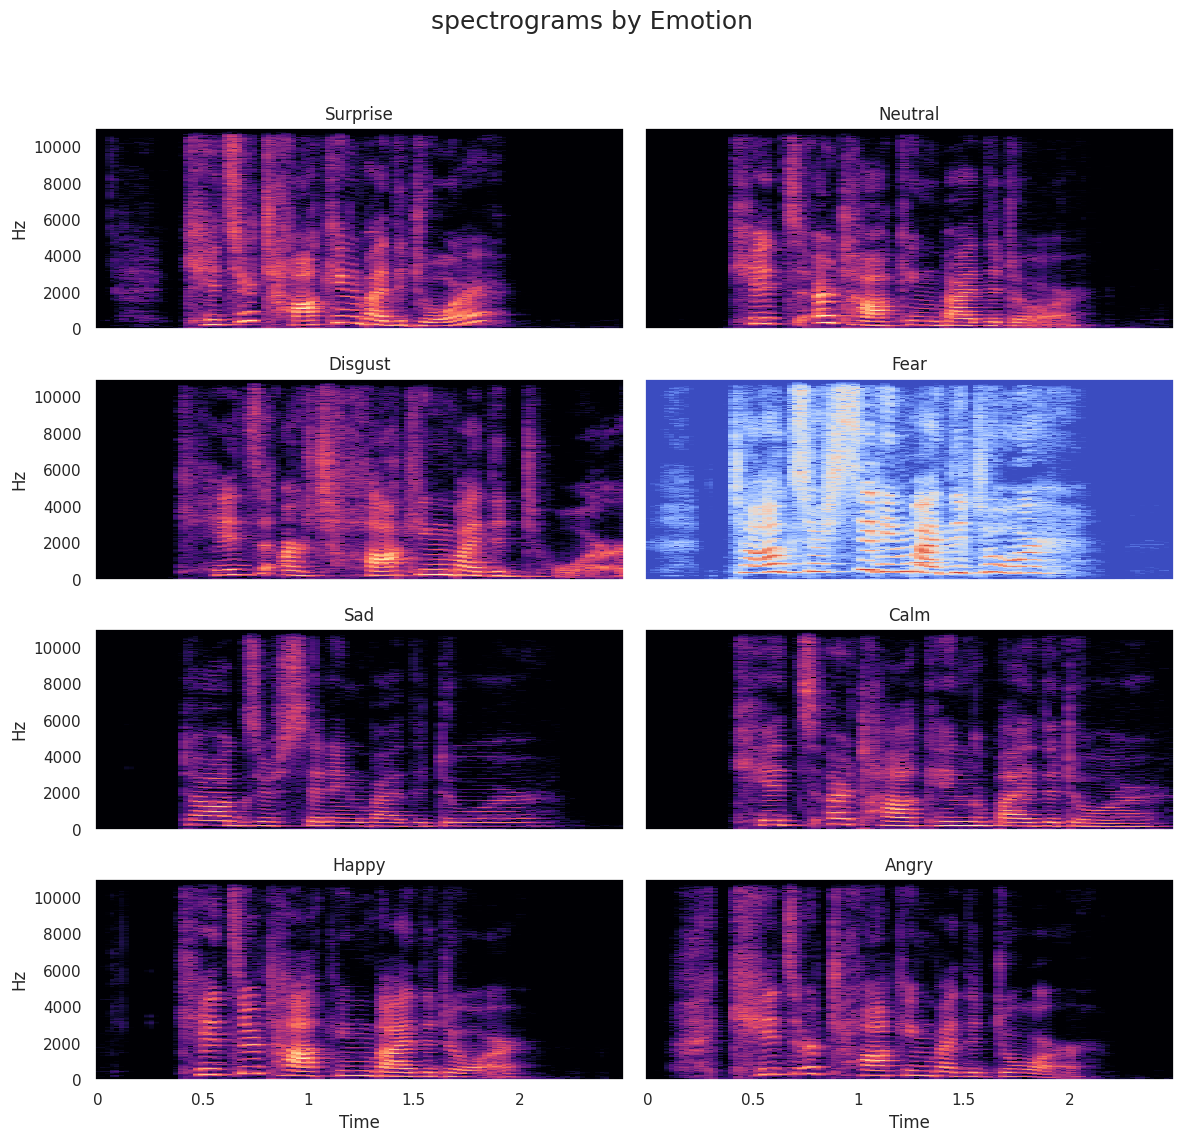

In [5]:
def create_spectrogram_grid(data, emotions_list):
    fig, axes = plt.subplots(4, 2, figsize=(12, 12))
    fig.suptitle("spectrograms by Emotion", fontsize=18)
    axes = axes.flatten()

    for idx, emotion in enumerate(emotions_list[:8]): 
        try:
            path = np.array(data.Path[data.Emotions == emotion])[0]
            audio_data, sr = librosa.load(path, duration=2.5, offset=0.6)
            stft = librosa.stft(audio_data)
            db = librosa.amplitude_to_db(np.abs(stft))

            librosa.display.specshow(db, sr=sr, x_axis='time', y_axis='hz', ax=axes[idx])
            axes[idx].set_title(emotion.capitalize())
            axes[idx].label_outer()
        except Exception as e:
            axes[idx].set_visible(False)
            print(f"Erro com emoção '{emotion}': {e}")

    for i in range(len(emotions_list), len(axes)):
        axes[i].set_visible(False)
    
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(EmotionData, "spectrograms_plot.png"))
    plt.show()

emotions = data.Emotions.unique()[:8]
create_spectrogram_grid(data, emotions)

1. Surprise
- Aktivitas frekuensi tinggi (hingga 10kHz) terlihat kuat.
- Variasi spektrum intens — bisa jadi karena nada naik mendadak.
2. Neutral
- Energi tersebar secara konsisten dan lebih “rata”.
- Tidak terlalu banyak variasi frekuensi tinggi — cocok dengan suara netral yang cenderung datar.
3. Disgust
- Ciri mirip dengan Surprise, tapi dengan lebih sedikit energi tinggi.
- Bisa jadi menunjukkan suara yang cepat namun bernada berat.
4. Fear
- Sangat mencolok: background lebih terang (biru) — noise lebih dominan?
- Ini bisa menunjukkan tekanan atau napas tidak teratur dalam suara.
5. Sad
- Energi lebih rendah, dominan di bawah 4000 Hz.
- Tampak lebih tenang, lambat — konsisten dengan ekspresi sedih.
6. Calm
- Mirip Sad tapi dengan sedikit lebih banyak distribusi energi frekuensi.
- Lebih stabil — karakteristik tenang dan konsisten.
7. Happy
- Distribusi energi kuat di banyak frekuensi.
- Cenderung dinamis dan cerah, sesuai karakter emosinya.
8. Angry
- Pola sangat intens seperti Happy, tapi lebih agresif (lebih banyak frekuensi rendah).
- Ada puncak-puncak energi tiba-tiba — cocok dengan suara marah.


# Feature Extraction and Data Augmentation

## Extract Features
- **Zero Crossing Rate (ZCR)**: Mengukur seberapa sering sinyal berubah tanda.
- **Chroma STFT**: Menangkap profil kelas nada (pitch class).
- **MFCC**: Mel-Frequency Cepstral Coefficients, representasi ringkas dari envelope spektral.
- **RMS**: Energi akar rata-rata kuadrat dari sinyal.
- **Mel Spectrogram**: Merepresentasikan kekuatan frekuensi pada skala mel.

## Data Augmentation
- **`noise(data)`**: Menambahkan noise Gaussian ke sinyal.
- **`stretch(data, rate)`**: Merenggangkan sinyal dalam waktu (mengubah kecepatan).
- **`pitch(data, sample_rate, steps)`**: Menggeser nada (pitch) dari sinyal.

## Get Features
- Memuat klip audio (2,5 detik, dimulai dari offset 0,6 detik).
- Mengekstrak fitur dari:
  - Audio asli.
  - Versi dengan noise.
  - Versi yang diubah pitch dan kecepatan.
- Mengembalikan matriks di mana setiap baris adalah vektor fitur dari versi audio yang berbeda.

In [6]:
def extract_features(data, sample_rate):
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    return result

def noise(data):
    noise_amp = 0.005 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch(data, sample_rate, steps=4):
    return librosa.effects.pitch_shift(y=data, sr=sample_rate, n_steps=steps)

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    result = np.array(extract_features(data, sample_rate))
    noise_data = noise(data)
    result = np.vstack((result, extract_features(noise_data, sample_rate)))
    stretched = stretch(data)
    pitched = pitch(stretched, sample_rate)
    result = np.vstack((result, extract_features(pitched, sample_rate)))
    return result

X, Y = [], []
for path, emotion in tqdm(zip(data.Path, data.Emotions), total=len(data)):
    features = get_features(path)
    for f in features:
        X.append(f)
        Y.append(emotion)

X = np.array(X)
Y = np.array(Y)

100%|██████████| 1440/1440 [03:43<00:00,  6.44it/s]


In [7]:
len(X), len(Y), data.Path.shape

(4320, 4320, (1440,))

## Saving Extracted Features to CSV


In [8]:
Features = pd.DataFrame(X)
Features['labels'] = Y
os.makedirs('EmotionData', exist_ok=True)
Features.to_csv(os.path.join('EmotionData', "data.csv"), index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.237382,0.682273,0.670519,0.614793,0.579039,0.566803,0.637206,0.667451,0.663883,0.669903,...,0.000234,0.000235,0.000138,0.000128,0.000299,0.000360,0.000275,0.000173,2.896729e-05,surprise
1,0.261904,0.692754,0.692555,0.661710,0.623034,0.627198,0.682977,0.684963,0.675950,0.672424,...,0.000242,0.000241,0.000142,0.000135,0.000302,0.000368,0.000284,0.000181,3.502539e-05,surprise
2,0.206485,0.675004,0.688609,0.712476,0.710047,0.643870,0.597580,0.552463,0.500956,0.517249,...,0.000058,0.000037,0.000046,0.000030,0.000048,0.000047,0.000057,0.000027,2.675169e-06,surprise
3,0.256113,0.621621,0.580278,0.598515,0.628296,0.598015,0.597272,0.650352,0.698636,0.681863,...,0.000018,0.000016,0.000013,0.000012,0.000007,0.000008,0.000008,0.000005,5.802852e-07,neutral
4,0.249539,0.639862,0.624454,0.621592,0.693631,0.680670,0.652997,0.620734,0.688253,0.718669,...,0.000023,0.000020,0.000016,0.000016,0.000011,0.000012,0.000012,0.000009,4.472353e-06,neutral


# Feature and Label Preprocessing

In [9]:
def preprocess_features_labels(df):
    X = df.iloc[:, :-1].values
    Y = df['labels'].values
    encoder = OneHotEncoder(sparse_output=False)
    Y = encoder.fit_transform(Y.reshape(-1, 1))
    return X, Y, encoder

def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, scaler

def prepare_for_model(X):
    return np.expand_dims(X, axis=2)

# Data Splitting, Scaling, and Reshaping

In [10]:
X, Y, encoder = preprocess_features_labels(Features)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

X_train, X_test, scaler = scale_features(X_train, X_test)

X_train = prepare_for_model(X_train)
X_test = prepare_for_model(X_test)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Unique labels (one-hot):", y_train.shape[1])

Train shape: (3456, 162, 1)
Test shape: (864, 162, 1)
Unique labels (one-hot): 8


## 🔧 Membangun Model CNN 1D untuk Klasifikasi Emosi dari Suara

1. Lapisan Input
    - Menerima input dengan bentuk `(jumlah_fitur, 1)`, menyesuaikan dengan data audio yang telah diproses (misalnya fitur MFCC).
2. Blok Conv1D Pertama
    - **256 filter** dengan ukuran kernel **5**.
    - Aktivasi **ReLU**.
    - Padding **'same'** untuk mempertahankan panjang input.
    - **MaxPooling1D** dengan pool size **2** untuk mengurangi dimensi fitur.
    - **Dropout** sebesar **20%** untuk regularisasi.
3. Blok Conv1D Kedua
    - **128 filter**, kernel size **5**, aktivasi **ReLU**, dan padding **'same'**.
    - MaxPooling dan Dropout seperti pada blok pertama.
4. Lapisan Flatten
    - Mengubah hasil feature map dari Conv1D menjadi vektor 1 dimensi.
5. Lapisan Dense
    - **64 unit** dengan aktivasi **ReLU**.
6. Dropout Tambahan
    - Dropout sebesar **50%** untuk mencegah overfitting.
7. Lapisan Output
    - Dense layer dengan **jumlah unit = jumlah kelas emosi**.
    - Aktivasi **softmax** untuk klasifikasi multi-kelas (output berupa probabilitas setiap kelas).

### Kompilasi Model
- Optimizer: **Adam**
- Loss: **Categorical Crossentropy** (karena target label dalam format one-hot encoding)
- Metrik evaluasi: **Accuracy**

In [11]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))

model.add(Conv1D(512, kernel_size=5, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(256, kernel_size=5, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=5, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

I0000 00:00:1749131584.113830      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 162, 512)            │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 81, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 81, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 81, 256)             │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 41, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 41, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 41, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2688)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         172,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 995,272 (3.80 MB)

 Trainable params: 995,272 (3.80 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training with Callbacks

- **Callbacks Used**:
  - `EarlyStopping`: Monitors validation loss and stops training if no improvement is seen for 10 consecutive epochs, restoring the best weights.
  - `ModelCheckpoint`: Saves the model weights to `'best_model.h5'` whenever validation loss improves, ensuring the best model is retained.
  - `ReduceLROnPlateau`: Reduces the learning rate by half if validation loss plateaus for 10 epochs, down to a minimum of 0.0001, to help fine-tune training.

- The model is trained for up to 200 epochs with a batch size of 32.
- Validation data (`X_test`, `y_test`) is used to monitor performance and trigger callbacks.
- Verbose output is disabled (`verbose=0`) for cleaner logs.

This setup helps avoid overfitting, ensures model checkpoints, and adapts learning rate dynamically to improve training efficiency.


In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.0001)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=200,             
    batch_size=128,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    verbose=0
)

I0000 00:00:1749131588.652168      73 service.cc:148] XLA service 0x7a56a800def0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749131588.652642      73 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749131588.974970      73 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749131593.381325      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 1.73600, saving model to best_model.h5

Epoch 2: val_loss improved from 1.73600 to 1.62775, saving model to best_model.h5

Epoch 3: val_loss improved from 1.62775 to 1.61112, saving model to best_model.h5

Epoch 4: val_loss improved from 1.61112 to 1.48195, saving model to best_model.h5

Epoch 5: val_loss improved from 1.48195 to 1.42494, saving model to best_model.h5

Epoch 6: val_loss improved from 1.42494 to 1.33648, saving model to best_model.h5

Epoch 7: val_loss improved from 1.33648 to 1.28796, saving model to best_model.h5

Epoch 8: val_loss improved from 1.28796 to 1.24363, saving model to best_model.h5

Epoch 9: val_loss improved from 1.24363 to 1.19077, saving model to best_model.h5

Epoch 10: val_loss improved from 1.19077 to 1.17997, saving model to best_model.h5

Epoch 11: val_loss improved from 1.17997 to 1.14269, saving model to best_model.h5

Epoch 12: val_loss improved from 1.14269 to 1.06777, saving model to best_model.h5

Epoc

# Model Evaluation and Visualization

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8046 - loss: 0.6955
Accuracy of our model on test data: 80.43981194496155 %


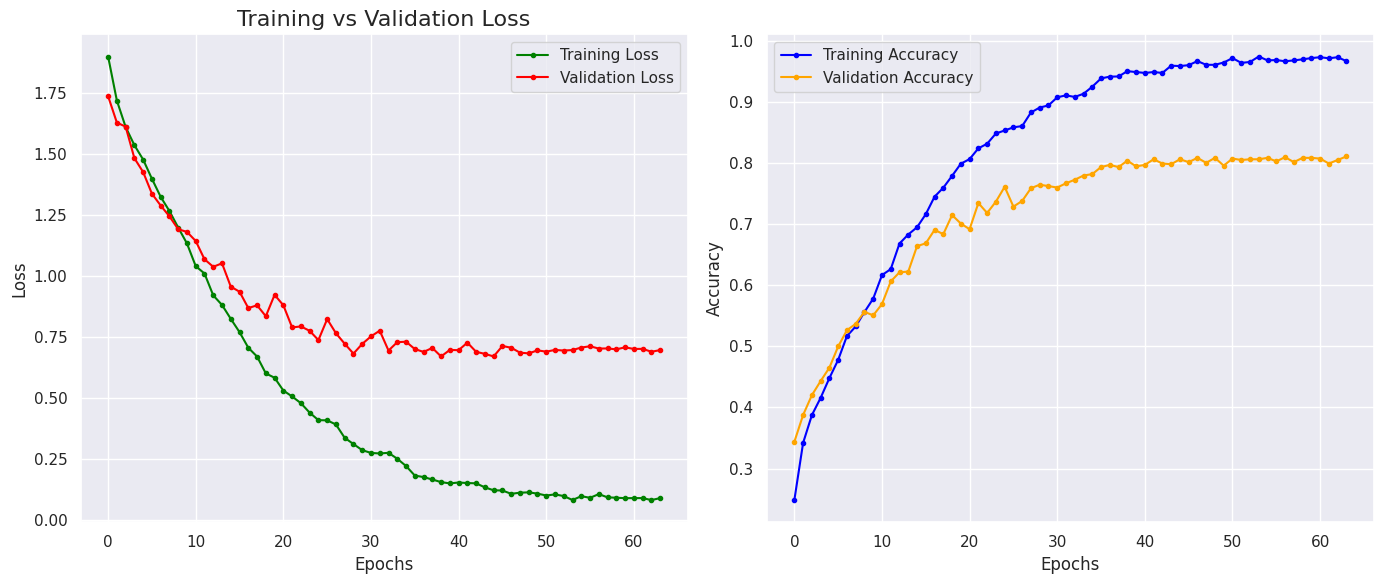

In [ ]:
print("Accuracy of our model on test data:", model.evaluate(X_test, y_test)[1] * 100, "%")

epochs = range(len(history.history['loss']))

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

ax[0].plot(epochs, train_loss, label='Training Loss', color='green', marker='.')
ax[0].plot(epochs, val_loss, label='Validation Loss', color='red', marker='.')
ax[0].set_title('Training vs Validation Loss', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].legend()
ax[0].grid(True)

ax[1].plot(epochs, train_acc, label='Training Accuracy', color='blue', marker='.')
ax[1].plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='.')
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Accuracy', fontsize=12)
ax[1].legend()
ax[1].grid(True)


os.makedirs('Results', exist_ok=True)
Results = "/Results"
plt.tight_layout()
plt.savefig(os.path.join(Results, "metrics_plot.png"))
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


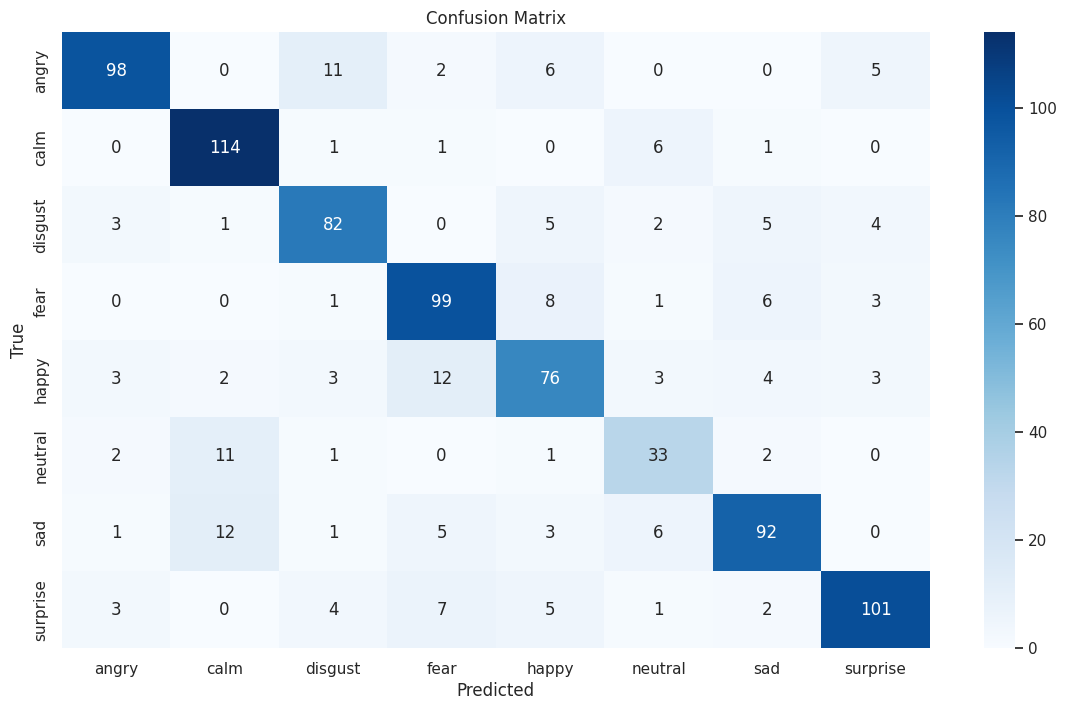

In [14]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

class_labels = encoder.categories_[0]

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(Results, "CM_plot.png"))
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


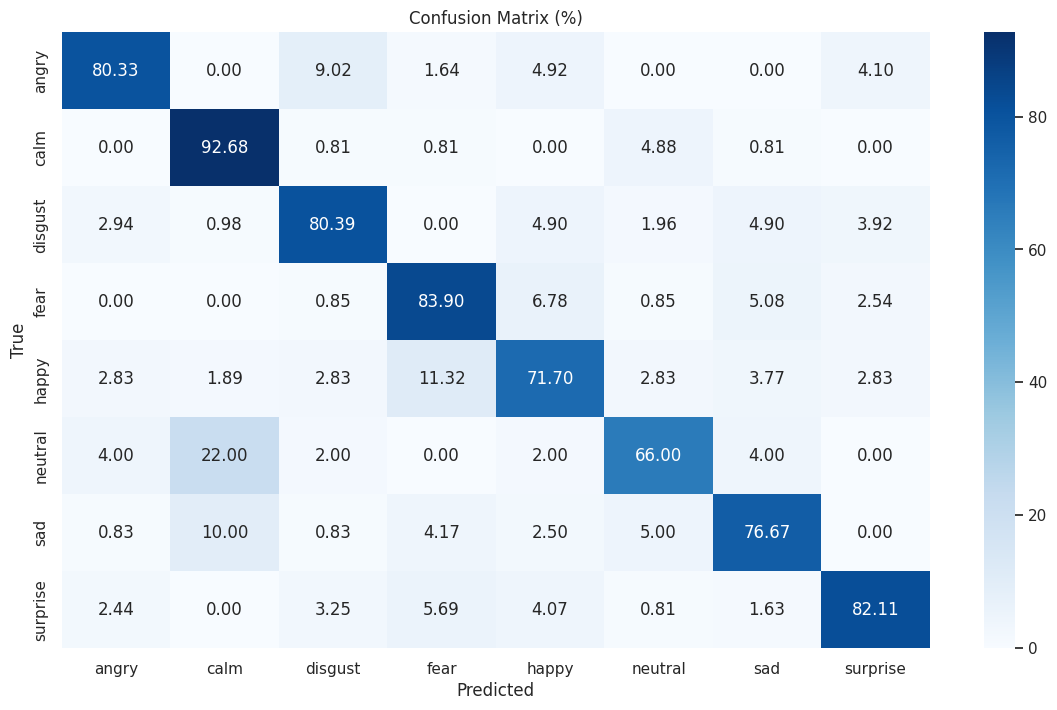

In [15]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

class_labels = encoder.categories_[0]

cm = confusion_matrix(y_true, y_pred)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_percentage = np.round(cm_percentage * 100, 2)

plt.figure(figsize=(14, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (%)')
plt.savefig(os.path.join(Results, "CM_porcentage_plot.png"))
plt.show()

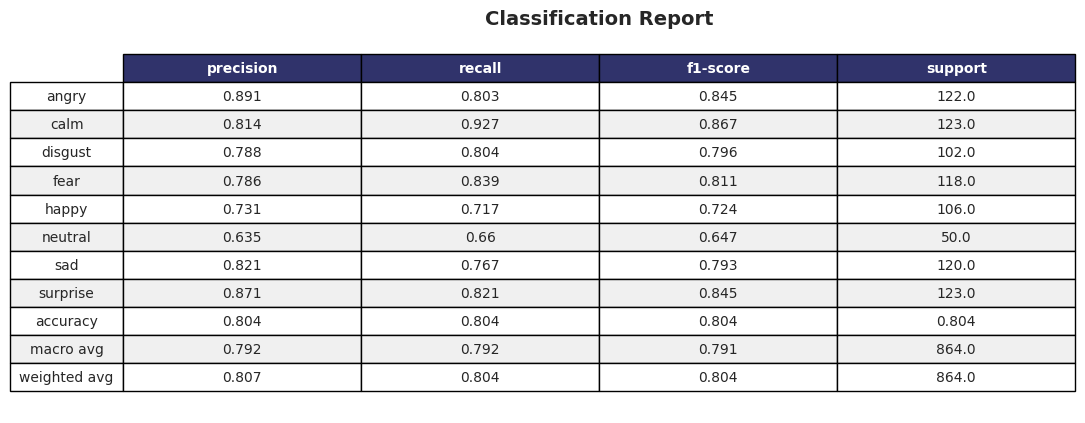

In [ ]:

class_names = encoder.categories_[0]  

report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

report_df = pd.DataFrame(report_dict).transpose().round(3)

os.makedirs("Results", exist_ok=True)
csv_path = "Results/classification_report.csv"
report_df.to_csv(csv_path, index=True)

fig, ax = plt.subplots(figsize=(11, len(report_df) * 0.4))
ax.axis('off')

table = ax.table(
    cellText=report_df.values,
    colLabels=report_df.columns,
    rowLabels=report_df.index,
    cellLoc='center',
    rowLoc='center',
    loc='center',
    colColours=["#30336b"] * len(report_df.columns)
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.1, 1.5)

for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#30336b')
    elif row % 2 == 0:
        cell.set_facecolor('#f0f0f0')
    else:
        cell.set_facecolor('#ffffff')

plt.title("Classification Report", fontsize=14, weight='bold')
plt.tight_layout()

img_path = "Results/classification_report_plot.png"
plt.savefig(img_path, dpi=300)
plt.show()